## Demo_ActDist
This is a demo for visualizing the class distribution of top-k images which activate the Neurons of a Neuron network most.

To run this demo from scratch, you need first generate a BadNet attack result by using the following cell

In [ ]:
! python ../../attack/badnet.py --save_folder_name badnet_demo

or run the following command in your terminal

```python attack/badnet.py --save_folder_name badnet_demo```

### Step 1: Import modules and set arguments

In [1]:
import sys, os
import yaml
import torch
import numpy as np
import torchvision.transforms as transforms
import matplotlib
from matplotlib.patches import Rectangle, Patch

sys.path.append("../")
sys.path.append("../../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.fix_random import fix_random
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.save_load_attack import load_attack_result
from utils.defense_utils.dbd.model.utils import (
    get_network_dbd,
    load_state,
    get_criterion,
    get_optimizer,
    get_scheduler,
)
from utils.defense_utils.dbd.model.model import SelfModel, LinearModel


In [2]:
### Basic setting: args
args = get_args(True)

########## For Demo Only ##########
args.yaml_path = "../../"+args.yaml_path
args.result_file_attack = "badnet_demo"
######## End For Demo Only ##########

with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../..//record/" + args.result_file_attack


### Step 2: Load data

In [3]:
# Load result
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")
selected_classes = np.arange(args.num_classes)

# Select classes to visualize
if args.num_classes>args.c_sub:
    selected_classes = np.delete(selected_classes, args.target_class)
    selected_classes = np.random.choice(selected_classes, args.c_sub-1, replace=False)
    selected_classes = np.append(selected_classes, args.target_class)

# keep the same transforms for train and test dataset for better visualization
result_attack["clean_train"].wrap_img_transform = result_attack["clean_test"].wrap_img_transform 
result_attack["bd_train"].wrap_img_transform = result_attack["bd_test"].wrap_img_transform 

# Create dataset
if args.visual_dataset == 'mixed':
    bd_test_with_trans = result_attack["bd_test"]
    visual_dataset = generate_mix_dataset(bd_test_with_trans, args.target_class, args.pratio, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'clean_train':
    clean_train_with_trans = result_attack["clean_train"]
    visual_dataset = generate_clean_dataset(clean_train_with_trans, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'clean_test':
    clean_test_with_trans = result_attack["clean_test"]
    visual_dataset = generate_clean_dataset(clean_test_with_trans, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'bd_train':  
    bd_train_with_trans = result_attack["bd_train"]
    visual_dataset = generate_bd_dataset(bd_train_with_trans, args.target_class, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'bd_test':
    bd_test_with_trans = result_attack["bd_test"]
    visual_dataset = generate_bd_dataset(bd_test_with_trans, args.target_class, selected_classes, max_num_samples=args.n_sub)
else:
    assert False, "Illegal vis_class"

print(f'Create visualization dataset with \n \t Dataset: {args.visual_dataset} \n \t Number of samples: {len(visual_dataset)}  \n \t Selected classes: {selected_classes}')

# Create data loader
data_loader = torch.utils.data.DataLoader(
    visual_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

# Create denormalization function
for trans_t in data_loader.dataset.wrap_img_transform.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)



Files already downloaded and verified
Files already downloaded and verified
loading...
create mix dataset with length:  10000
max_num_samples is given, use sample number limit now.
subset mix dataset with length:  4997
Create visualization dataset with 
 	 Dataset: mixed 
 	 Number of samples: 4997  
 	 Selected classes: [0 1 2 3 4 5 6 7 8 9]


### Step 3: Load model

In [4]:
# Load result
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")

# Load model
model_visual = generate_cls_model(args.model, args.num_classes)
model_visual.load_state_dict(result_attack["model"])
model_visual.to(args.device)
# !!! Important to set eval mode !!!
model_visual.eval()
print(f"Load model {args.model} from {args.result_file_attack}")


Files already downloaded and verified
Files already downloaded and verified
loading...
Load model preactresnet18 from badnet_demo


### Step 4: Get Activation Distribution

In [5]:
module_dict = dict(model_visual.named_modules())
module_names = module_dict.keys()

# Plot Conv2d or Linear
module_visual = [i for i in module_dict.keys() if isinstance(
    module_dict[i], torch.nn.Conv2d) or isinstance(module_dict[i], torch.nn.Linear) or isinstance(module_dict[i], torch.nn.BatchNorm2d)]

poi_indicator = np.array(get_poison_indicator_from_bd_dataset(visual_dataset))
labels = np.array(get_true_label_from_bd_dataset(visual_dataset))


df = None

# decide the number of images to compute the distribution
num_image = int(len(visual_dataset)/len(selected_classes)) 
if poi_indicator.sum() > 0:
    num_image = poi_indicator.sum()
    # regard the poisoned images as a class with label args.num_classes
    labels[poi_indicator==1] = args.num_classes
    
print(f'Visualize Top-{num_image} Samples from {len(visual_dataset)} Samples.')

label_set = np.unique(labels)
label_set.sort()

max_num_neuron = 0
for module_name in module_visual:
    target_layer = module_dict[module_name]
    print(f'Collecting features from module {target_layer}')

    features, labels, poi_indicator = get_features(
        args, model_visual, target_layer, data_loader, reduction='sum', activation= None)

    # set the poisoned images as a class with label args.num_classes for each iteration. 
    # this can be skipped if shuffle is set to False.
    labels[poi_indicator==1]=args.num_classes
    total_neuron = features.shape[1]
    max_num_neuron = np.max([max_num_neuron, total_neuron])
    top_indx = np.argsort(-features, axis=0)[:num_image, :]
    top_pred = np.array(labels)[top_indx]

    for neuron_i in range(total_neuron):
        base_row = {}
        base_row['layer'] = module_name
        base_row['Neuron'] = neuron_i
        for i in range(len(label_set)):
            base_row[f'percent_{i}'] = np.sum(
                top_pred[:, neuron_i] == label_set[i])/num_image
        if df is None:
            df = pd.DataFrame.from_dict([base_row])
        else:
            df.loc[df.shape[0]] = base_row

Visualize Top-500 Samples from 4997 Samples.


### Step 5: Show the Activation Distribution

ploting conv1
ploting layer1.0.bn1
ploting layer1.0.conv1
ploting layer1.0.bn2
ploting layer1.0.conv2
ploting layer1.1.bn1
ploting layer1.1.conv1
ploting layer1.1.bn2
ploting layer1.1.conv2
ploting layer2.0.bn1
ploting layer2.0.conv1
ploting layer2.0.bn2
ploting layer2.0.conv2
ploting layer2.0.shortcut.0
ploting layer2.1.bn1
ploting layer2.1.conv1
ploting layer2.1.bn2
ploting layer2.1.conv2
ploting layer3.0.bn1
ploting layer3.0.conv1
ploting layer3.0.bn2
ploting layer3.0.conv2
ploting layer3.0.shortcut.0
ploting layer3.1.bn1
ploting layer3.1.conv1
ploting layer3.1.bn2
ploting layer3.1.conv2
ploting layer4.0.bn1
ploting layer4.0.conv1
ploting layer4.0.bn2
ploting layer4.0.conv2
ploting layer4.0.shortcut.0
ploting layer4.1.bn1
ploting layer4.1.conv1
ploting layer4.1.bn2
ploting layer4.1.conv2
ploting linear


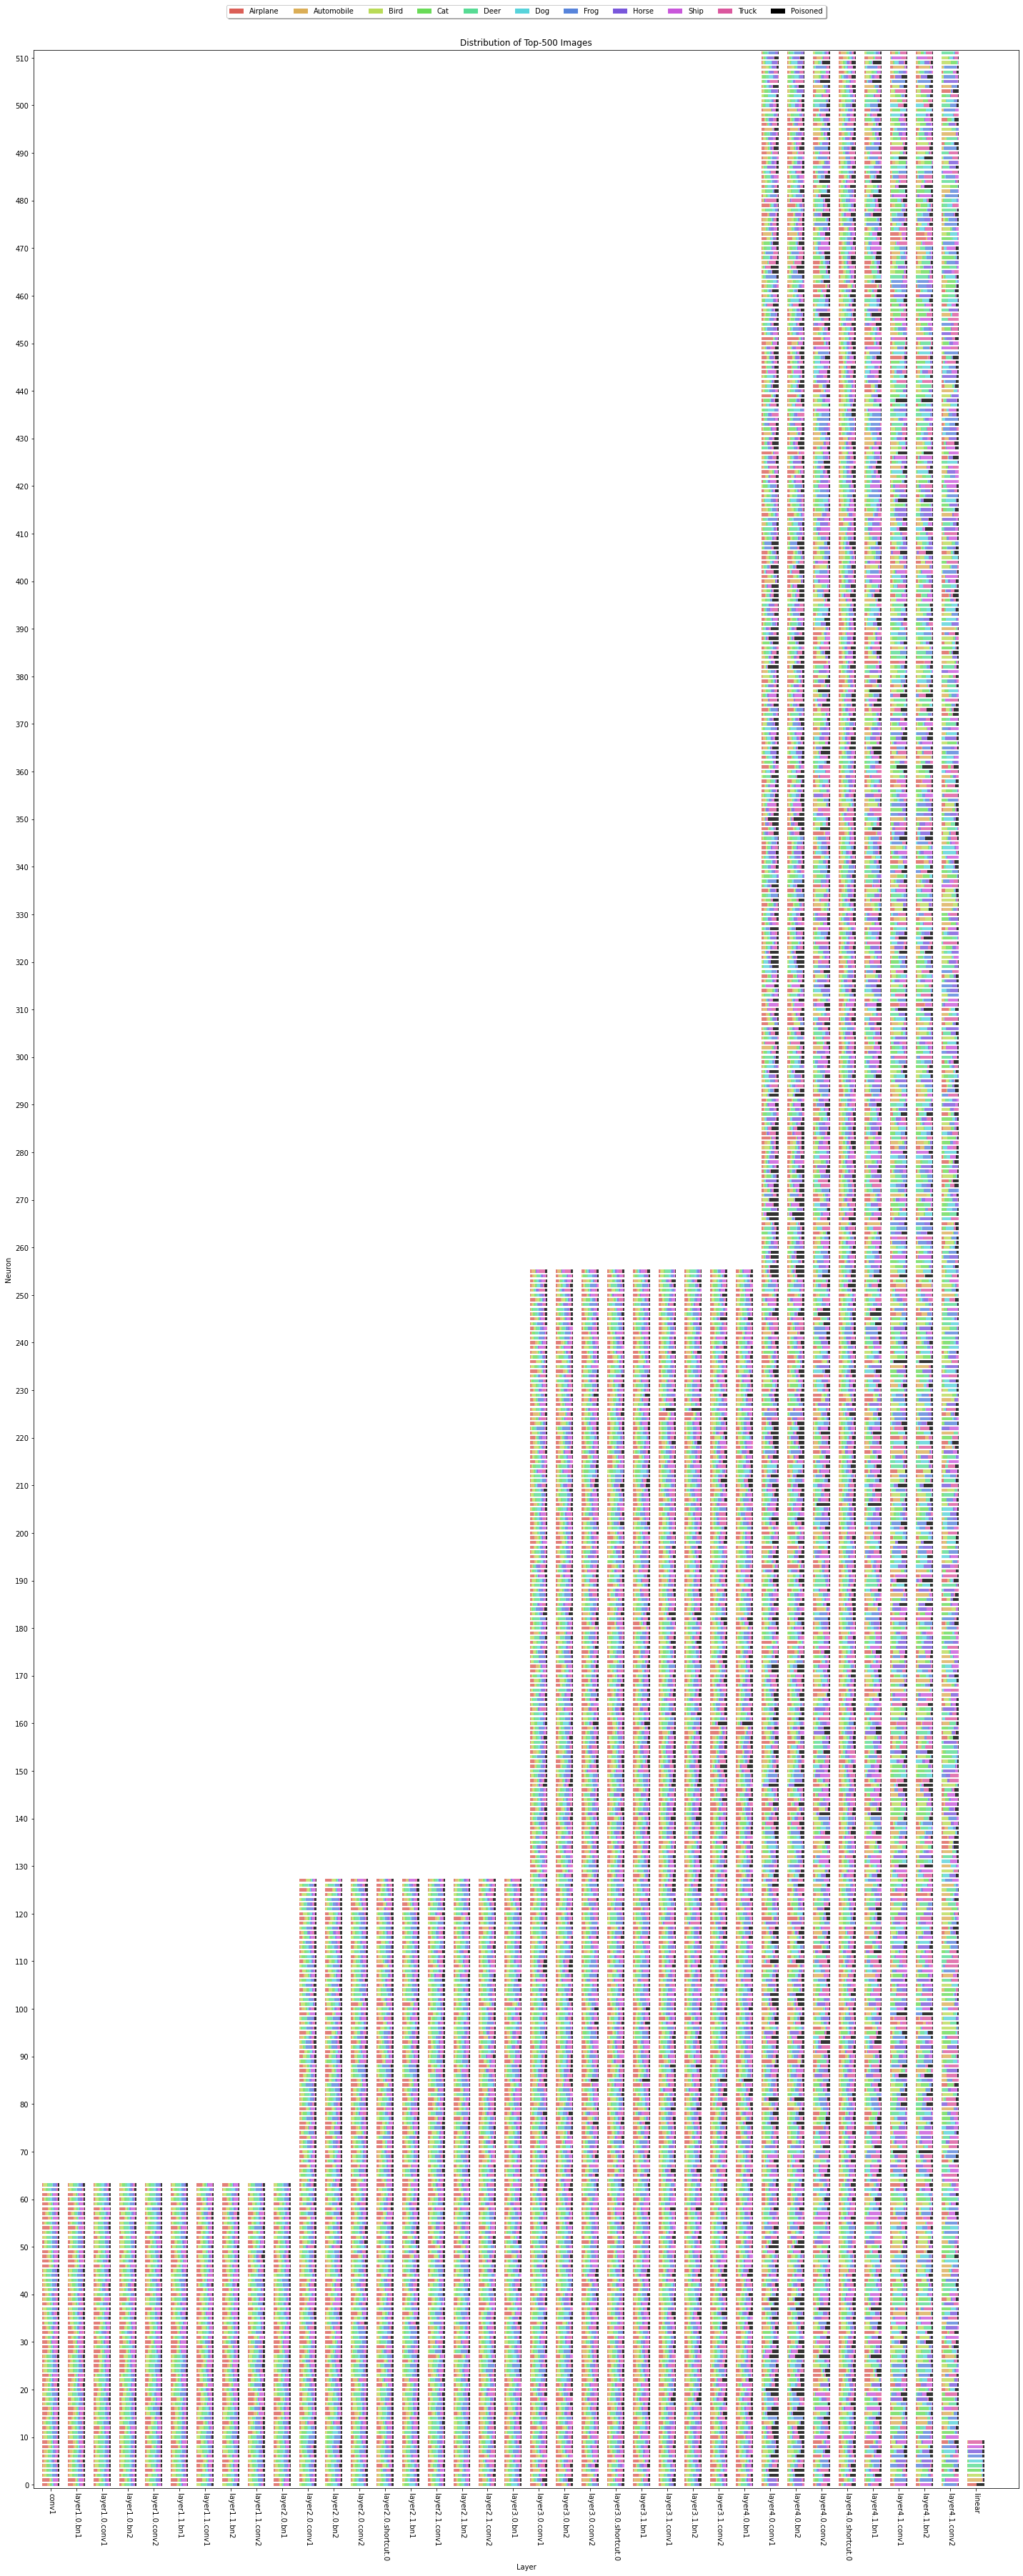

In [6]:
# define Matplotlib figure and axis
fig, ax = plt.subplots(figsize=(20, 50))
# create simple line plot
ax.plot([0, 0], [0, 0])

labels = np.array(get_true_label_from_bd_dataset(visual_dataset))
custom_palette = sns.color_palette("hls", np.unique(labels).shape[0])
if poi_indicator.sum() > 0:
    custom_palette.append((0.0, 0.0, 0.0))  # Black for poison samples

start_x0 = 0
height = 1
width = 1
max_num_neuron = df.Neuron.max()

for module_name in module_visual:
    print(f'ploting {module_name}')
    y_0 = 0
    layer_info = df[df.layer == module_name]
    total_neuron = layer_info.shape[0]
    for neuron_i in range(total_neuron):
        x_0 = start_x0
        base_row = layer_info.iloc[neuron_i]
        for i in range(len(label_set)):
            ax.add_patch(Rectangle((x_0, y_0), width*base_row[f'percent_{i}'], height,
                         facecolor=custom_palette[i],
                         fill=True,
                         lw=5,
                         alpha=0.8))

            x_0 += width*base_row[f'percent_{i}']
        y_0 += 1.5*height
    start_x0 += 1.5*width
x_loc = [0.5*width+1.5*width*i for i in range(len(module_visual))]
y_loc = [0.5*height+1.5*height*i for i in range(max_num_neuron)]

ax.set_xlim(xmin=-0.5*width, xmax=1.5*width*(len(module_visual)+1))
ax.set_ylim(ymin=-0.5*height, ymax=1.5*height*(max_num_neuron+1))
ax.set_xticks(x_loc, module_visual, rotation=270)
ax.set_yticks(y_loc[::10], np.arange(max_num_neuron)[::10])
ax.set_title(f'Distribution of Top-{num_image} Images')
ax.set_ylabel('Neuron')
ax.set_xlabel('Layer')

classes = args.class_names
if poi_indicator.sum() > 0:
    classes +=  ["poisoned"]
    
# map the label to class name in the order of colors/indexes
label_class = [classes[i].capitalize() for i in label_set]
legend_elements = [Patch(facecolor=custom_palette[i],
                         label=label_class[i]) for i in range(len(label_class))]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(
    0.5, 1.02), ncol=len(label_class), fancybox=True, shadow=True)


plt.tight_layout()